# Predecessor follower model predictive control study - velocity dynamics

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [2]:
from utils.step_reference import gen_step_ref
from dyn.linear_long_vel import LinearLongVel
from alg.sparse_quad_pfmpc_vel import SparseQuadPFMPCVel

### Platoon parameters

In [3]:
H = 100    # planning horizon
N = 7     # number of vehicles in platoon, including leader
dt = 0.1  # timestep
total_time = 12.0  # seconds
total_time += dt * H
d_des = 5   # desired spacing

# dynamics stuff
v_min, v_max = 15., 30.
x_min = np.array([-np.inf, v_min])
x_max = np.array([np.inf, v_max])
u_min = np.array([v_min])
u_max = np.array([v_max])
tau = 0.2
dyn = LinearLongVel(dt, x_min, x_max, u_min, u_max, tau)
n, m = dyn.n, dyn.m

a_max = 5.

q = 1
q_p = 1
r = 1
Q = np.array([[100., 0], [0, 1]])
Q_p = np.array([[100., 0], [0, 1]])
R = r * np.eye(m)
pfmpc = SparseQuadPFMPCVel(Q, Q_p, R, dyn, v_min, v_max, a_max, H)

### Reference trajectory - Acceleration

In [4]:
dist_start = 1.0
dist_end = 2.0
v_start = 20.
v_end = 22.

x_ref, t_range = gen_step_ref(total_time, dt, dist_start, dist_end, 
                              v_start, v_end)
x_ref = x_ref[:2, :]
T = len(t_range)
t_range_mpc = t_range[:T-H]

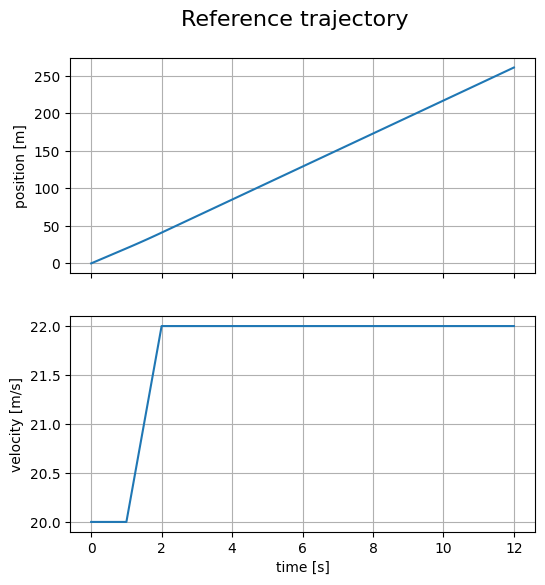

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
fig.suptitle("Reference trajectory", size=16)
fig.subplots_adjust(top=0.9)

for i in range(x_ref.shape[0]):
    ax[i].plot(t_range[:T-H], x_ref[i, :T-H])
    ax[i].grid()
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[1].set_xlabel("time [s]");

### Leader reference tracking

In [6]:
x_track = np.zeros((n, T-H))
u_track = np.zeros((m, T-H-1))

# initial condition
x_track[:, 0] = x_ref[:, 0]

# initialized assumed states, controls, and outputs for first timestep
x_a_track = np.zeros((n, H + 1))
x_a_track[:, 0] = x_track[:, 0]
u_a_track = x_a_track[1, 0] * np.ones((m, H))
for k in range(H):
    x_a_track[:, k+1] = dyn.forward(x_a_track[:, k], u_a_track[:, k])

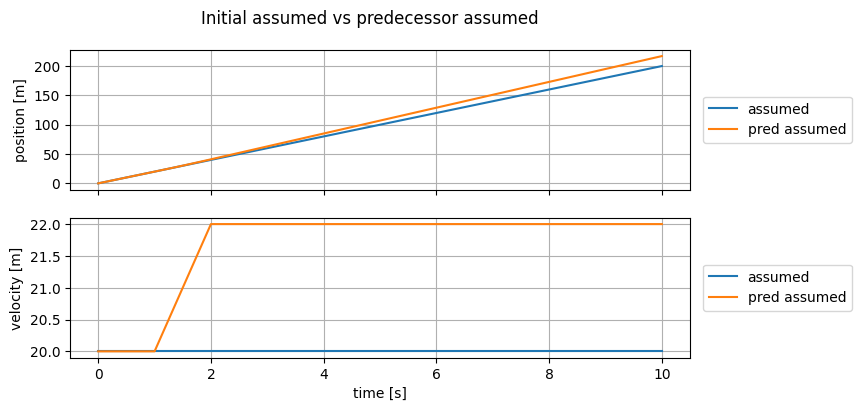

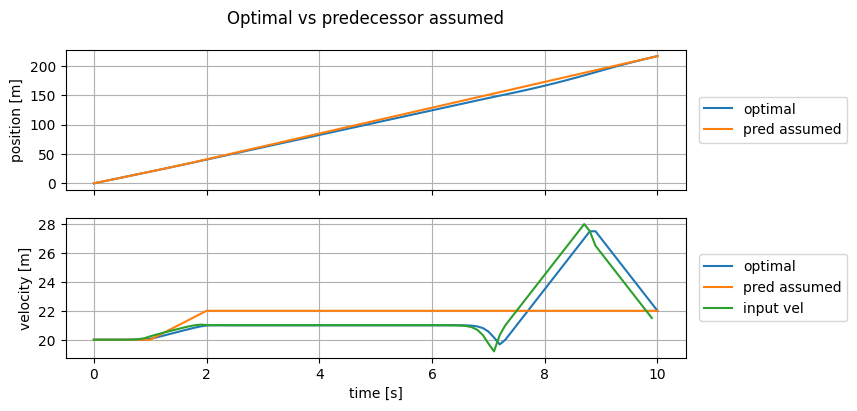

In [7]:
x_0 = x_ref[:, 0]
x_a = copy.deepcopy(x_a_track)
x_pred_a = x_ref[:, 0:H+1]

assumed_cost = 0.0
D = np.zeros(((H-1)*m, H*m))
for i in range((H-1)*m):
    D[i, i] = -1
    D[i, i+1] = 1
assumed_cost += r * np.linalg.norm(D @ u_a_track[0, :]) ** 2
# print(assumed_cost)
for i in range(H):
    assumed_cost += (x_a[:, i] - x_pred_a[:, i]) @ (Q_p @ (x_a[:, i] - x_pred_a[:, i]))

fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
fig.suptitle("Initial assumed vs predecessor assumed")
ax[0].plot(t_range[0:H+1], x_a[0, :], label="assumed")
ax[0].plot(t_range[0:H+1], x_pred_a[0, :], label="pred assumed")
ax[1].plot(t_range[0:H+1], x_a[1, :], label="assumed")
ax[1].plot(t_range[0:H+1], x_pred_a[1, :], label="pred assumed")
ax[0].grid()
ax[1].grid()
ax[0].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m]")
ax[1].set_xlabel("time [s]")

u_opt, x_opt, prob = pfmpc.control(x_0, x_a, x_pred_a, 0.)
# print(f"u_opt:\n{u_opt}")
# print(f"x_opt:\n{x_opt}")

fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
fig.suptitle("Optimal vs predecessor assumed")
ax[0].plot(t_range[0:H+1], x_opt[0, :], label="optimal")
ax[0].plot(t_range[0:H+1], x_pred_a[0, :], label="pred assumed")
ax[1].plot(t_range[0:H+1], x_opt[1, :], label="optimal")
ax[1].plot(t_range[0:H+1], x_pred_a[1, :], label="pred assumed")
ax[1].plot(t_range[0:H], u_opt[0, :], label="input vel")
ax[0].grid()
ax[1].grid()
ax[0].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m]")
ax[1].set_xlabel("time [s]");

In [8]:
start_time = time.time()
for k in tqdm(range(T - H - 1)):
    x_0 = x_track[:, k]
    x_a = copy.deepcopy(x_a_track)
    x_pred_a = x_ref[:, k:k+H+1]
    d = 0.

    # z_opt, prob = pfmpc.control(x_0, x_a, x_pred_a, d)
    u_opt, x_opt, prob = pfmpc.control(x_0, x_a, x_pred_a, d)
    if prob.status != 'optimal':
        print(f"timestep {k}, problem returned: {prob.status}")
        break

    u_track[:, k] = u_opt[:, 0]
    x_track[:, k+1] = dyn.forward(x_0, u_opt[:, 0])

    # update assumed state, control, output
    u_a_track[:, :H-1] = u_opt[:, 1:H]
    u_a_track[:, H-1] = np.zeros((m))
    x_a_track[:, 0] = x_opt[:, 1]
    for t in range(H):
        x_a_track[:, t+1] = dyn.forward(x_a_track[:, t], u_a_track[:, t])
    
end_time = time.time()
avg_time = (end_time - start_time) / (T - H)

100%|██████████| 120/120 [00:01<00:00, 98.76it/s] 


In [9]:
print(f"pf mpc leader track avg rate: {1 / avg_time} Hz")
print("\nproblem data:")
print(f"    scalar variables: {prob.size_metrics.num_scalar_variables}")
print(f"    scalar eq constraints: {prob.size_metrics.num_scalar_eq_constr}")
print(f"    scalar ineq constraints: {prob.size_metrics.num_scalar_leq_constr}")

pf mpc leader track avg rate: 98.60862475853544 Hz

problem data:
    scalar variables: 694
    scalar eq constraints: 596
    scalar ineq constraints: 398


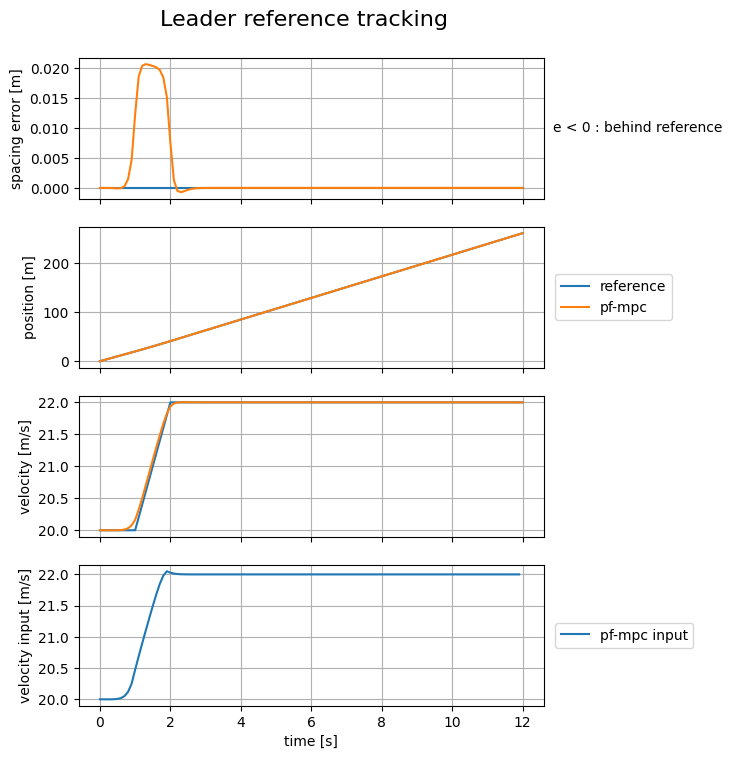

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
fig.suptitle("Leader reference tracking", size=16)
fig.subplots_adjust(top=0.92)

ax[0].plot(t_range[:T-H], np.zeros(T-H), label="reference")
ax[0].plot(t_range[:T-H], x_track[0, :T-H] - x_ref[0, :T-H], label="pf-mpc")
ax[0].grid()
ax[3].grid()
ax[0].text(1.02, 0.5, "e < 0 : behind reference", va='center', 
           transform=ax[0].transAxes)
for i in range(1, x_ref.shape[0] + 1):
    ax[i].plot(t_range_mpc, x_ref[i-1, :T-H], label="reference")
    ax[i].grid()

ax[1].plot(t_range_mpc, x_track[0, :], label="pf-mpc")
ax[2].plot(t_range_mpc, x_track[1, :], label="pf-mpc")
ax[3].plot(t_range_mpc[:-1], u_track[0, :], label="pf-mpc input")

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("position [m]")
ax[2].set_ylabel("velocity [m/s]")
ax[3].set_ylabel("velocity input [m/s]")
ax[3].set_xlabel("time [s]")
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax[3].legend(bbox_to_anchor=(1.01, 0.5), loc="center left");

## Predecessor follower platoon analysis

In [11]:
x_pfmpc = [np.zeros((n, T-H)) for _ in range(N + 1)]
u_pfmpc = [np.zeros((m, T-H-1)) for _ in range(N + 1)]

# zeroth vehicle is virtual leader
x_pfmpc[0] = x_ref[:, :T-H]
u_pfmpc[0][:, :T-H-1] = x_ref[1, :T-H-1]

# initial condition: start in correct place with desired spacing, velocity, and 
# acceleration
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    x_pfmpc[i][:, 0] = np.array([-(i-1)*d, x_pfmpc[0][1, 0]])

# initialize assumed states, controls, and output for first timestep
x_a_pfmpc = [np.zeros((n, H + 1)) for _ in range(N + 1)]
x_a_pfmpc[0] = x_pfmpc[0][:, :H+1]
for i in range(1, N + 1):
    x_a_pfmpc[i][:, 0] = x_pfmpc[i][:, 0]

u_a_pfmpc = [u_pfmpc[0][0, 0] * np.ones((m, H)) for _ in range(N + 1)]
u_a_pfmpc[0] = u_pfmpc[0][:H]

for i in range(1, N+1):
    for k in range(H):
        x_a_pfmpc[i][:, k+1] = dyn.forward(x_a_pfmpc[i][:, k], 
                                           u_a_pfmpc[i][:, k])

x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

In [12]:
start_time = time.time()
no_soln = False
for k in tqdm(range(T - H - 1)):
    for i in range(1, N + 1):
        x_0 = x_pfmpc[i][:, k]
        x_a = x_a_pfmpc_prev[i]
        x_pred_a = x_a_pfmpc_prev[i-1]
        d = 0 if i == 1 else d_des

        # z_opt, prob = pfmpc[i].control(x_0, x_a, x_pred_a, d)
        u_opt, x_opt, prob = pfmpc.control(x_0, x_a, x_pred_a, d)
        if prob.status != 'optimal':
            print(f"timestep {k}, vehicle {i}, problem returned: {prob.status}")
            no_soln = True
            break

        u_pfmpc[i][:, k] = u_opt[:, 0]
        x_pfmpc[i][:, k+1] = dyn.forward(x_pfmpc[i][:, k], u_opt[:, 0])

        # update assumed state, control, input
        u_a_pfmpc[i][:, :H-1] = u_opt[:, 1:H]
        u_a_pfmpc[i][0, H-1] = x_opt[1, H]
        x_a_pfmpc[i][:, 0] = x_opt[:, 1]
        for t in range(H):
            x_a_pfmpc[i][:, t+1] = dyn.forward(x_a_pfmpc[i][:, t], 
                                               u_a_pfmpc[i][:, t])
    
    if no_soln:
        fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
        fig.suptitle(f"timestep {k}, vehicle {i} failure", size=16)
        fig.subplots_adjust(top=0.9)
        for i in range(N+1):
            ax[0].plot(t_range[:H+1], x_a_pfmpc_prev[i][0, :], 
                       label=f"{i} assumed")
            ax[1].plot(t_range[:H+1], x_a_pfmpc_prev[i][1, :], 
                       label=f"{i} assumed")
        ax[0].set_ylabel("position [m]")
        ax[0].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
        ax[1].set_ylabel("velocity [m/s]")
        ax[1].set_xlabel("time [s]")
        ax[1].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
        break
    
    x_a_pfmpc[0] = x_ref[:, k+1:k+H+2]
    u_a_pfmpc[0] = x_ref[1, k+1:k+H+1]

    x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
    u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

end_time = time.time()
avg_time = (end_time - start_time) / (i * (k+1))

100%|██████████| 120/120 [00:08<00:00, 14.62it/s]


In [13]:
print(f"\npf-mpc average rate: {1 / avg_time} Hz")


pf-mpc average rate: 102.33376013846134 Hz


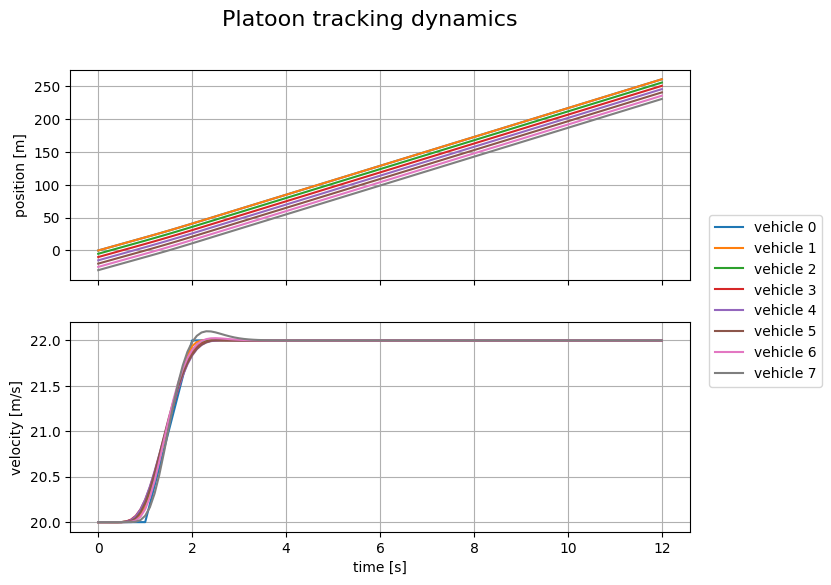

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon tracking dynamics", size=16)
fig.subplots_adjust(top=0.88)

ax[0].plot(t_range_mpc, x_pfmpc[0][0, :], label=f"vehicle 0")
ax[1].plot(t_range_mpc, x_pfmpc[0][1, :], label=f"vehicle 0")
for i in range(1, N + 1, round(N / 10)):
    ax[0].plot(t_range_mpc, x_pfmpc[i][0, :], label=f"vehicle {i}")
    ax[1].plot(t_range_mpc, x_pfmpc[i][1, :], label=f"vehicle {i}")

ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[0].legend(bbox_to_anchor=(1.02, -0.1), loc="center left")

In [15]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = (i-1) * d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[0][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[0][1, :]

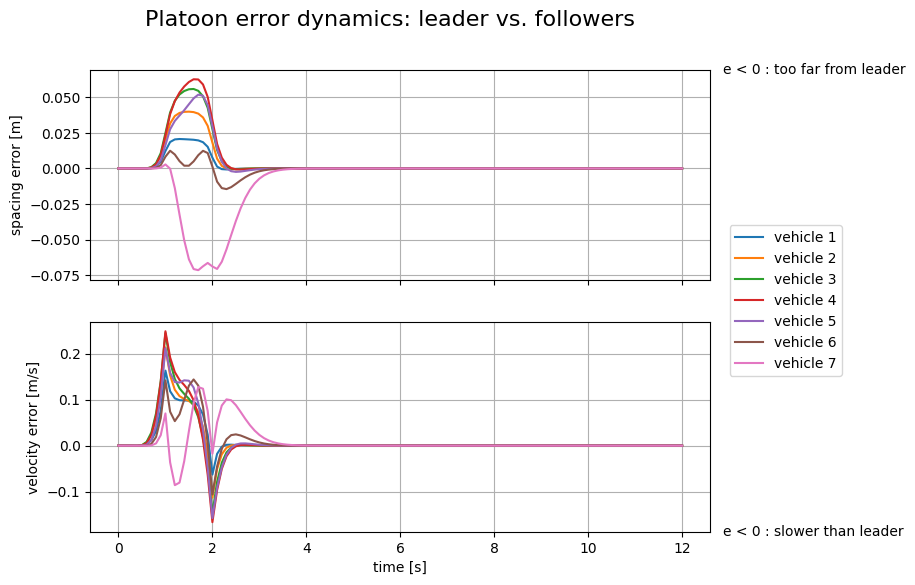

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: leader vs. followers", size=16)
fig.subplots_adjust(top=0.88)

for i in range(1, N+1, round(N / 10)):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from leader", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than leader", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left");

In [17]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[i-1][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[i-1][1, :]

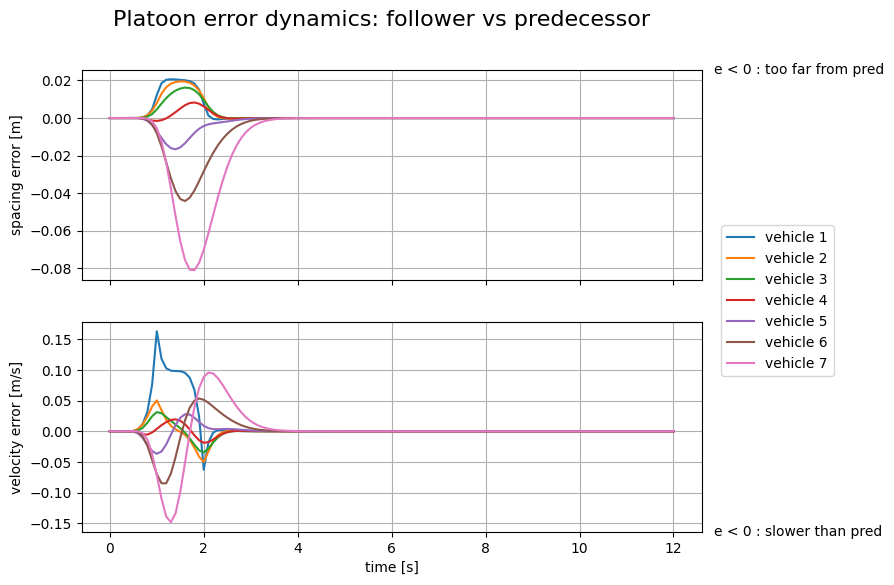

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: follower vs predecessor", size=16)
fig.subplots_adjust(top=0.88)

for i in range(1, N + 1, round(N / 10)):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from pred", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than pred", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left");